[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ferit-osirv/lab6_home/blob/main/lab6_home.ipynb)


## Lab 6: Feature Detection and Image Retrieval

In this lab, you will develop an image retrieval algorithm. Image retrieval involves finding images within a large dataset that match a given query image. For example, if the query image features the Eiffel Tower, the image retrieval algorithm should identify and retrieve all images containing the Eiffel Tower.

**Note:** Depending on your group ID, you will later be assigned a specific landmark and method combination in this notebook.

## Resources

Most of the resources required for this assignment can be found in this guide:

[OpenCV Documentation: Feature Detection and Description](https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html)

Please read through all sections, paying particular attention to the section relevant to your assigned method and the "Feature Matching" section. The "Feature Matching" section will be essential for implementing this assignment.

## Image Retrieval Algorithm

The algorithm will operate as follows:

**Step 1:** Perform feature matching between each query image and every search image using a feature detection algorithm such as FAST, SIFT, etc.

**Step 2:** If there are more than a certain number of matches (e.g., 10) between a query and a search image, we can conclude that the search image contains the landmark. This result is stored as either true or false.

**Step 3:** Calculate the true positive and false positive rates to evaluate the algorithm's performance.

**Algorithm in Pseudocode**

Input: A list of query images featuring a specific landmark, a list of images for searching, some of which contain the landmark and some that do not, and a threshold value (e.g., 10) for the number of matches required to confirm the presence of the landmark in an image.

```python
image_contains_landmark = []
for each image with index i:
  image_contains_landmark[i] = false

for each query image:
  for each image with index i:
    matches = match_features(query, image)
    if matches count > threshold:
      image_contains_landmark[i] = true
```

**Feature Matching**

The feature matching process should proceed in several steps (as explained in the "Feature Matching" section referenced above):

**Step 1:** Conduct feature detection on the query image.

**Step 2:** Perform feature detection on the search image.

**Step 3:** Use **FLANN (Fast Approximate Nearest Neighbor Search Library)** to match the features of the query and search image.

**Step 4:** Implement **Lowe's ratio test** to retain only features below a certain distance threshold.

**Step 5:** Return the matches that are above the distance threshold.

## Dataset Downloading Code

The code block below downloads the following dataset:

https://github.com/filipradenovic/revisitop (rparis6k)
published in: Radenović, F., Iscen, A., Tolias, G., Avrithis, Y., & Chum, O. (2018). Revisiting Oxford and Paris: Large-Scale Image Retrieval Benchmarking. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 5706-5715.

The dataset contains thousands of images of various landmarks in Paris, France. It also contains query images for each landmark, and labels of which landmark is on each image.

The code block also defines helper functions which will be explained later in the notebook.

**⚠️ Click the ▶️ button to run the cell below.** The download will take a couple of minutes.

In [40]:
import os
import urllib.request
import tarfile

def download_datasets(data_dir):
    """
    DOWNLOAD_DATASETS Checks, and, if required, downloads the necessary datasets for the testing.

        download_datasets(DATA_ROOT) checks if the data necessary for running the example script exist.
        If not it downloads it in the folder structure:
            DATA_ROOT/datasets/roxford5k/ : folder with Oxford images
            DATA_ROOT/datasets/rparis6k/  : folder with Paris images
    """

    # Create data folder if it does not exist
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

    # Create datasets folder if it does not exist
    datasets_dir = os.path.join(data_dir, 'datasets')
    if not os.path.isdir(datasets_dir):
        os.mkdir(datasets_dir)

    # Download datasets folders datasets/DATASETNAME/
    datasets = ['rparis6k']
    for di in range(len(datasets)):
        dataset = datasets[di]

        if dataset == 'roxford5k':
            src_dir = 'https://www.robots.ox.ac.uk/~vgg/data/oxbuildings'
            dl_files = ['oxbuild_images-v1.tgz']
        elif dataset == 'rparis6k':
            src_dir = 'https://www.robots.ox.ac.uk/~vgg/data/parisbuildings'
            dl_files = ['paris_1-v1.tgz', 'paris_2-v1.tgz']
        else:
            raise ValueError('Unknown dataset: {}!'.format(dataset))

        dst_dir = os.path.join(data_dir, 'datasets', dataset, 'jpg')
        if not os.path.isdir(dst_dir):
            print('>> Dataset {} directory does not exist. Creating: {}'.format(dataset, dst_dir))
            os.makedirs(dst_dir)
            for dli in range(len(dl_files)):
                dl_file = dl_files[dli]
                src_file = os.path.join(src_dir, dl_file)
                dst_file = os.path.join(dst_dir, dl_file)
                print('>> Downloading dataset {} archive {}...'.format(dataset, dl_file))
                os.system('wget {} -O {}'.format(src_file, dst_file))
                print('>> Extracting dataset {} archive {}...'.format(dataset, dl_file))
                # create tmp folder
                dst_dir_tmp = os.path.join(dst_dir, 'tmp')
                os.system('mkdir {}'.format(dst_dir_tmp))
                # extract in tmp folder
                os.system('tar -zxf {} -C {}'.format(dst_file, dst_dir_tmp))
                # remove all (possible) subfolders by moving only files in dst_dir
                os.system('find {} -type f -exec mv -i {{}} {} \\;'.format(dst_dir_tmp, dst_dir))
                # remove tmp folder
                os.system('rm -rf {}'.format(dst_dir_tmp))
                print('>> Extracted, deleting dataset {} archive {}...'.format(dataset, dl_file))
                os.system('rm {}'.format(dst_file))

        gnd_src_dir = os.path.join('http://cmp.felk.cvut.cz/revisitop/data', 'datasets', dataset)
        gnd_dst_dir = os.path.join(data_dir, 'datasets', dataset)
        gnd_dl_file = 'gnd_{}.pkl'.format(dataset)
        gnd_src_file = os.path.join(gnd_src_dir, gnd_dl_file)
        gnd_dst_file = os.path.join(gnd_dst_dir, gnd_dl_file)
        if not os.path.exists(gnd_dst_file):
            print('>> Downloading dataset {} ground truth file...'.format(dataset))
            os.system('wget {} -O {}'.format(gnd_src_file, gnd_dst_file))

download_datasets('images')

import matplotlib.pyplot as plt
import pickle
from PIL import Image, ImageFile

def pil_loader(path):
    # to avoid crashing for truncated (corrupted images)
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def configdataset(dataset, dir_main):

    dataset = dataset.lower()

    if dataset == 'roxford5k' or dataset == 'rparis6k':
        # loading imlist, qimlist, and gnd, in cfg as a dict
        gnd_fname = os.path.join(dir_main, dataset, 'gnd_{}.pkl'.format(dataset))
        with open(gnd_fname, 'rb') as f:
            cfg = pickle.load(f)
        cfg['gnd_fname'] = gnd_fname
        cfg['ext'] = '.jpg'
        cfg['qext'] = '.jpg'

    elif dataset == 'revisitop1m':
        # loading imlist from a .txt file
        cfg = {}
        cfg['imlist_fname'] = os.path.join(dir_main, dataset, '{}.txt'.format(dataset))
        cfg['imlist'] = read_imlist(cfg['imlist_fname'])
        cfg['qimlist'] = []
        cfg['ext'] = ''
        cfg['qext'] = ''

    cfg['dir_data'] = os.path.join(dir_main, dataset)
    cfg['dir_images'] = os.path.join(cfg['dir_data'], 'jpg')

    cfg['n'] = len(cfg['imlist'])
    cfg['nq'] = len(cfg['qimlist'])

    cfg['im_fname'] = config_imname
    cfg['qim_fname'] = config_qimname

    cfg['dataset'] = dataset

    return cfg

def config_imname(cfg, i):
    return os.path.join(cfg['dir_images'], cfg['imlist'][i] + cfg['ext'])

def config_qimname(cfg, i):
    return os.path.join(cfg['dir_images'], cfg['qimlist'][i] + cfg['qext'])

def read_imlist(imlist_fn):
    with open(imlist_fn, 'r') as file:
        imlist = file.read().splitlines()
    return imlist

cfg = configdataset('rparis6k', os.path.join('images', 'datasets'))

def get_query_imgs(landmark):
  imgs = []
  for i in range(cfg['nq']):
    if landmark in cfg['qim_fname'](cfg, i):
      qim = pil_loader(cfg['qim_fname'](cfg, i)).crop(cfg['gnd'][i]['bbx'])
      imgs.append(qim)
  return imgs

def get_imgs(landmark):
  imgs = []
  for i in range(cfg['n']):
    if landmark in cfg['im_fname'](cfg, i):
      im = pil_loader(cfg['im_fname'](cfg, i))
      imgs.append(im)
  return imgs

def get_img_fnames(landmark):
  fnames = []
  for i in range(cfg['n']):
    if landmark in cfg['im_fname'](cfg, i):
      fnames.append(cfg['im_fname'](cfg, i))
  return fnames

num_imgs = cfg['n']

def get_img(i):
  return pil_loader(cfg['im_fname'](cfg, i))

def get_img_fname(i):
  return cfg['im_fname'](cfg, i)

>> Dataset rparis6k directory does not exist. Creating: images/datasets/rparis6k/jpg
>> Downloading dataset rparis6k archive paris_1-v1.tgz...
>> Extracting dataset rparis6k archive paris_1-v1.tgz...
>> Extracted, deleting dataset rparis6k archive paris_1-v1.tgz...
>> Downloading dataset rparis6k archive paris_2-v1.tgz...
>> Extracting dataset rparis6k archive paris_2-v1.tgz...
>> Extracted, deleting dataset rparis6k archive paris_2-v1.tgz...
>> Downloading dataset rparis6k ground truth file...


## Groups

In the notice of this lab, you received a group number.

**⚠️ Enter the assignment group id below and run the block get your landmark and method.**

In [51]:
# @title  { run: "auto", vertical-output: true }
group_id = 00 # @param {type:"integer"}
assert len(str(group_id)) == 2, "Incorrect group"

landmark_id = int(str(group_id)[0])
method_id = int(str(group_id)[1])

landmarks = ['pantheon', 'louvre', 'notredame', 'triomphe', 'eiffel']
methods = ['SIFT', 'ORB', 'FAST']

assert (landmark_id - 1) >= 0 and (landmark_id - 1) < len(landmarks)\
  and (method_id - 1) >= 0 and (method_id - 1) < len(methods), "Incorrect group"

landmark = landmarks[landmark_id - 1]
method = methods[method_id - 1]

print("Your landmark:", landmark)
print("Your feature detection method:", method)

AssertionError: Incorrect group

## Documentation

**Available predefined functions in this notebook**:


 - `get_query_imgs(landmark)` - load a list of query images
   - `landmark` can be `'pantheon', 'louvre', 'notredame', 'triomphe', 'eiffel'`.
 - `get_img(i)` - load the `i`th image from the dataset
 - `get_img_fname(i)` - returns the file name of the image
 - `num_imgs` - the total number of images in the dataset
 - `get_imgs(landmark)` - get all images of a certain landmark, useful for evaluation
 - `get_img_fnames(landmark)` - get all image filenames of a certain landmark, useful for evaluation

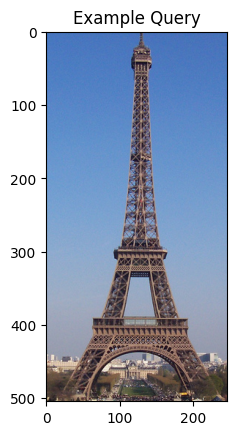

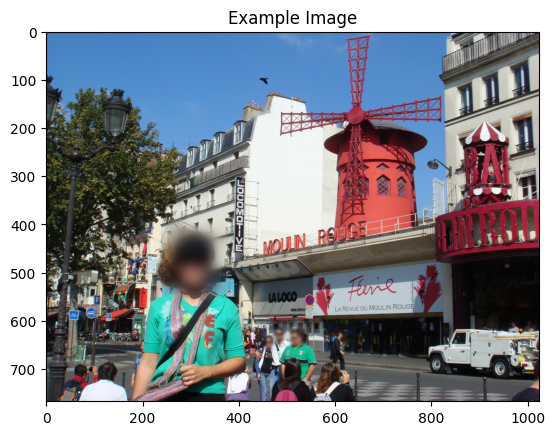

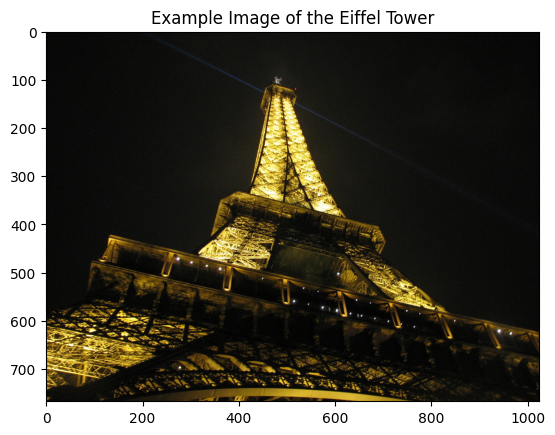

Image 40 images/datasets/rparis6k/jpg/paris_moulinrouge_000210.jpg
All Eiffel images ['images/datasets/rparis6k/jpg/paris_eiffel_000049.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000105.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000324.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000084.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000128.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000275.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000172.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000306.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000005.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000303.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000050.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000299.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000175.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000270.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000086.jpg', 'images/datasets/rparis6k/jpg/paris_eiffel_000302.jpg', 'images/datasets/r

In [ ]:
# Some example code

query_imgs = get_query_imgs('eiffel')
plt.imshow(query_imgs[0])
plt.title('Example Query');
plt.show()

example_img = get_img(40)
plt.imshow(example_img)
plt.title('Example Image');
plt.show()

example_eiffel_img = get_imgs('eiffel')[5]
plt.imshow(example_eiffel_img)
plt.title('Example Image of the Eiffel Tower');
plt.show()

print('Image 40', get_img_fname(40))
print('All Eiffel images', get_img_fnames('eiffel'))

## Assignment

In [ ]:
print(landmark)
query_imgs = get_query_imgs(landmark)

For algorithm development, it is faster to only go through known images of that landmark.

Later in the notebook, you will perform the search across all images.

Before you start development here, it might be a good idea to first try implementing feature matching for just one query and one search image. You can then convert that code to a for loop to go through multiple images as in the block below.

In [ ]:
known_landmark_imgs = get_imgs(landmark)
known_landmark_fnames = get_img_fnames(landmark)

# An array containing image filenames that correspond to the landmark,
# according to your image retrieval algorithm.
matched_fnames_temp = []

for query in query_imgs:
  for img, img_fname in zip(known_landmark_imgs, known_landmark_fnames):
    # TODO: Perform image retrieval using some feature extraction
    # algorithm...
    # Take a look at the resources above for similar code.
    is_match = False

    if is_match:
      matched_fnames_temp.append(img_fname)

# Remove duplicate filenames
matched_fnames_temp = list(set(matched_fnames_temp))
print(matched_fnames_temp)

Now, let's test on the whole dataset.

In [ ]:
# An array containing image filenames that correspond to the landmark,
# according to your image retrieval algorithm.
matched_fnames = []

for query in query_imgs:
  for i in range(num_imgs):
    img = get_img(i)
    img_fname = get_img_fname(i)

    # TODO: Perform image retrieval using some feature extraction
    # algorithm as above...
    is_match = False

    if is_match:
      matched_fnames.append(img_fname)

print(matched_fnames)

Evaluation: Calculate values of the confusion matrix.

https://en.wikipedia.org/wiki/Confusion_matrix

True positives: Landmark is detected by your algorithm and is really a landmark; i.e. landmark is in both `matched_fnames` and `known_landmark_fnames`.

False positives: Landmark is matched by your algorithm but in reality the image does not contain the landmark; i.e. landmark is in `matched_fnames` but not in `known_landmark_fnames`.

In [ ]:
# Calculate number of true positives and false positives
#
# True positives: Landmark is in both matched_fnames and known_landmark_fnames
# False positives: Landmark is in matched_fnames but not in known_landmark_fnames

def get_confusion_matrix(matched_fnames, known_landmark_fnames, num_imgs):
  '''
  matched_fnames: Your retrieval results from all images.
  known_landmark_fnames: Known GT landmark names.
  '''
  # TODO: Calculate the values
  tp = 0
  fp = 0
  fn = 0
  tn = num_imgs - (tp + fp + fn)
  return (tp, fp, tn, fn)

# Test if confusion matrix works correctly
matched_fnames_test = ['eiffel_0, eiffel_1, eiffel_2, louvre_0']
known_landmark_fnames_test = ['eiffer_0', 'eiffel_1', 'eiffel_2', 'eiffel_3']
# (tp, fp, tn, fn)
test_cm = (3, 1, num_imgs - (3 + 1 + 1), 1)
assert test_cm == get_confusion_matrix(matched_fnames_test, known_landmark_fnames_test, num_imgs),\
  "Your function is not implemented correctly."

In [ ]:
# Print the confusion matrix values

tp, fp, tn, fn = get_confusion_matrix(matched_fnames, known_landmark_fnames, num_imgs)
print(f'{tp}\t{fp}')
print(f'{fn}\t{tn}')

**Final step:** Try to modify your matches threshold to increase the number of true positives.